<a href="https://colab.research.google.com/github/steimel60/ML/blob/main/DeepLearning/BearClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 719 kB 5.3 MB/s 
     |████████████████████████████████| 1.2 MB 38.5 MB/s 
     |████████████████████████████████| 197 kB 30.0 MB/s 
     |████████████████████████████████| 59 kB 6.5 MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *

#Get 100 urls of Grizzly bear images
urls = search_images_ddg('grizzly bear', max_images=100)
len(urls),urls[0]

(100, 'https://bozone.com/site/wp-content/uploads/2019/03/GRIZZLY.jpeg')

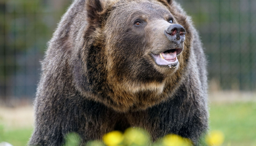

In [3]:
#Download and view image at the first url
download_url(urls[0], 'images/bear.jpg')
im = Image.open('images/bear.jpg')
im.thumbnail((256,256))
im

In [4]:
#Do this for each bear type

bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

if not path.exists():
  path.mkdir()
  for b in bear_types:
    dest = (path/b)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{b} bear', max_images=100)
    download_images(dest, urls=results)

fns = get_image_files(path)
fns

(#288) [Path('bears/teddy/00000012.jpg'),Path('bears/teddy/00000039.jpg'),Path('bears/teddy/00000074.jpg'),Path('bears/teddy/00000069.jpeg'),Path('bears/teddy/00000021.jpg'),Path('bears/teddy/00000030.jpg'),Path('bears/teddy/00000067.jpeg'),Path('bears/teddy/00000090.jpg'),Path('bears/teddy/00000068.jpg'),Path('bears/teddy/00000000.jpg')...]

In [5]:
#Remove corrupt downloads
failed = verify_images(fns)
failed.map(Path.unlink)

(#4) [None,None,None,None]

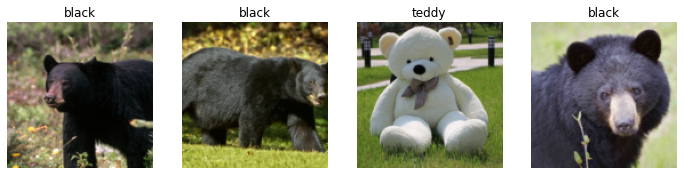

In [7]:
#Turn data into DataLoader object
#Need 4 things:
  #Data type
  #How to get list of items
  #Data labels
  #How to create validation set

#DataBlock provides template for DataLoader
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),             #Independent var: Image, Dependent var: type of bear (categorical)
    get_items=get_image_files,                      #Retrieve urls like we did above
    splitter=RandomSplitter(valid_pct=.2, seed=42), #Split into training and validation set
    get_y=parent_label,                             #Tell data loader how to create label, parent_label is fastai func that returns folder name
    item_tfms=Resize(128))                          #Transform items into 128x128 squares

#Create DataLoader from DataBlock
dls = bears.dataloaders(path)   #Returns dls for training and validation sets
dls.valid.show_batch(max_n=4, nrows=1)

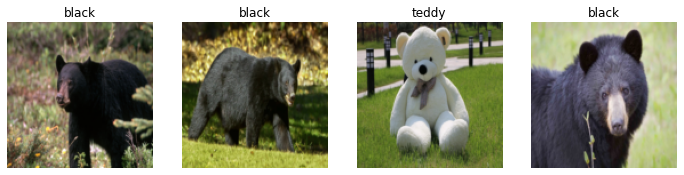

In [8]:
#by default resize crops the image
#we can tell fastai we prefer squishing
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

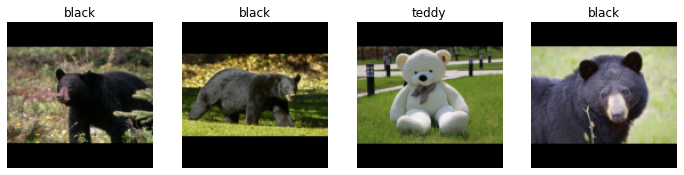

In [9]:
#or we can pad images with zeros (black)
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

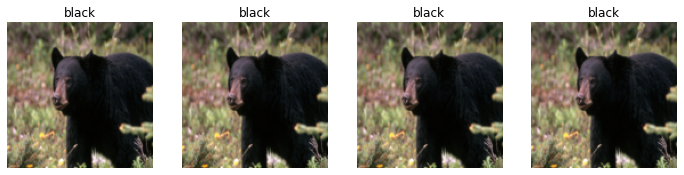

In [10]:
#Standard practice is to select random part of the image and crop that section
#using a different piece of the image on each epoch
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=.3))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1, unique=True) #unique=True will show different versions of the same image

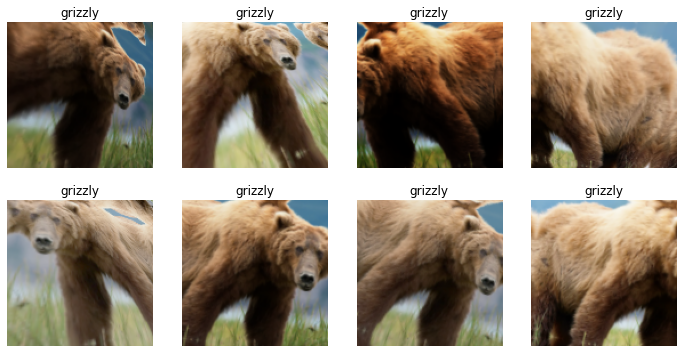

In [11]:
#Data Augmentation
#Simply creating random variations of the same data
#Common techniques: rotation, flipping, perspective warping, brightness and contrast changes

#Exaggerated example
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2)) #aug_transforms is a standard set of common transforms
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [12]:
#Training our model

#Reset our dataloader from examples above
bears = bears.new(item_tfms=RandomResizedCrop(224, min_scale=.5), batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

#Create our learner
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.811374,0.582229,0.214286,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.347178,0.192193,0.089286,00:39
1,0.209287,0.029038,0.000000,00:26
2,0.160092,0.007869,0.000000,00:27
3,0.126991,0.005991,0.000000,00:32


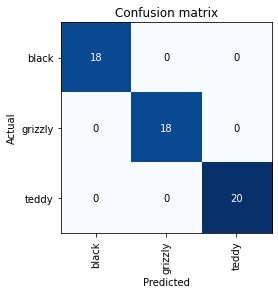

In [13]:
#Analyze Performance
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

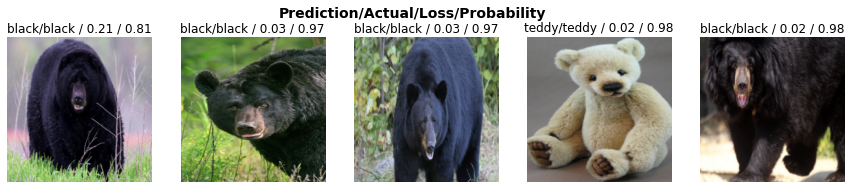

In [14]:
#View items with highest loss
interp.plot_top_losses(5, nrows=1)

In [16]:
#Export our model
learn.export()

In [17]:
#Check file exsits
path = Path()
path.ls(file_exts='.pkl') #This is the file needed wherever you export to

(#1) [Path('export.pkl')]

In [21]:
#Not practical, but we will test loading into this notebook

learn_inf = load_learner(path/'export.pkl')
learn_inf.predict(fns[3])

('teddy', TensorBase(2), TensorBase([1.2404e-07, 2.3604e-08, 1.0000e+00]))

In [20]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']